In [1]:
# Install ultralytics (YOLOv8)
!pip install ultralytics -q

# Verify installation
import ultralytics
ultralytics.checks()

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/112.6 GB disk)


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzip dataset (upload yolo_dataset.zip to your Drive first)
!unzip -q /content/drive/MyDrive/yolo_dataset.zip -d /content/

# Verify structure
!ls -la /content/yolo_dataset/
!ls /content/yolo_dataset/images/

total 24
drwxrwxrwx 4 root root 4096 Feb  5 20:42 .
drwxr-xr-x 1 root root 4096 Feb  8 19:54 ..
-rw-rw-rw- 1 root root  252 Feb  5 20:42 data.yaml
drwxrwxrwx 5 root root 4096 Feb  5 20:42 images
drwxrwxrwx 5 root root 4096 Feb  5 20:42 labels
test  train  val


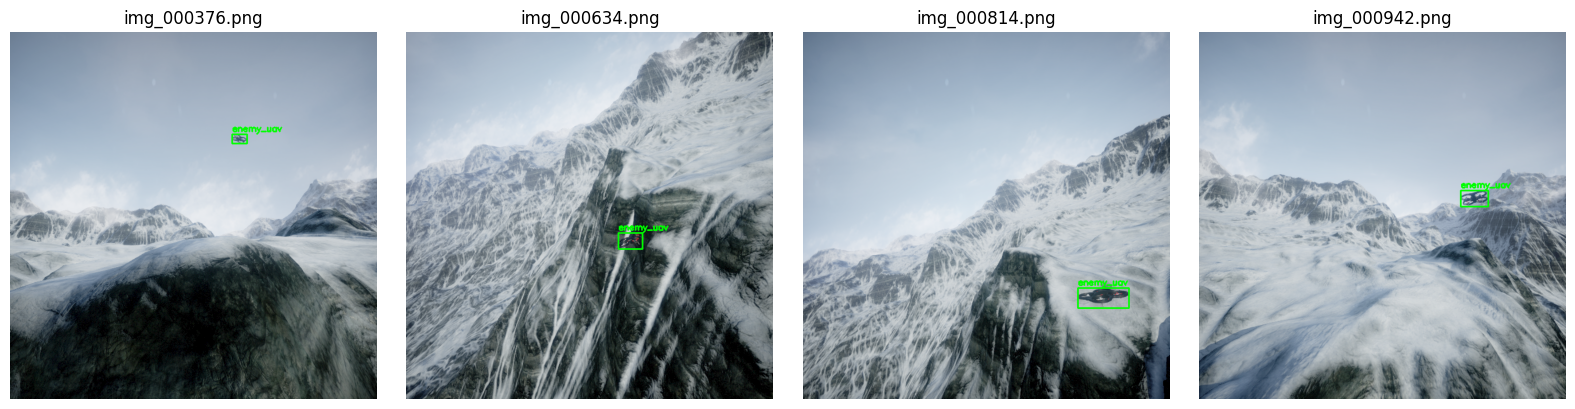

In [4]:
# Visualize sample data with bounding boxes
import cv2
import matplotlib.pyplot as plt
import os
import random

def visualize_sample(dataset_path, split='train', n_samples=4):
    img_dir = os.path.join(dataset_path, 'images', split)
    lbl_dir = os.path.join(dataset_path, 'labels', split)

    images = os.listdir(img_dir)
    samples = random.sample(images, min(n_samples, len(images)))

    fig, axes = plt.subplots(1, n_samples, figsize=(16, 4))

    for ax, img_name in zip(axes, samples):
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        lbl_path = os.path.join(lbl_dir, img_name.replace('.png', '.txt'))
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    cls, cx, cy, bw, bh = map(float, line.strip().split())
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, 'enemy_uav', (x1, y1-5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(img_name[:15])

    plt.tight_layout()
    plt.show()

visualize_sample('/content/yolo_dataset')

In [5]:
# Train YOLOv8 model
from ultralytics import YOLO

# Load pretrained YOLOv8n (nano - fast inference for real-time tracking)
model = YOLO('yolov8n.pt')

# Train the model
results = model.train(
    data='/content/yolo_dataset/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    name='simUAV_detector',
    patience=20,           # Early stopping
    save=True,
    plots=True,
    # Augmentations for better generalization
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=15.0,
    translate=0.1,
    scale=0.5,
    flipud=0.0,            # No vertical flip (sky/ground matters)
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.1
)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=simUAV_detector, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, 

In [6]:
# Evaluate model on test set
metrics = model.val(split='test')

print(f"mAP50:     {metrics.box.map50:.4f}")
print(f"mAP50-95:  {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall:    {metrics.box.mr:.4f}")

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 46.4±22.8 MB/s, size: 493.1 KB)
val: Scanning /content/yolo_dataset/labels/test... 50 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 198.5it/s 0.3s
val: New cache created: /content/yolo_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.2it/s 3.4s
                   all         50         50          1      0.999      0.995      0.844
Speed: 19.1ms preprocess, 11.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /content/runs/detect/val
mAP50:     0.9950
mAP50-95:  0.8444
Precision: 1.0000
Recall:    0.9985


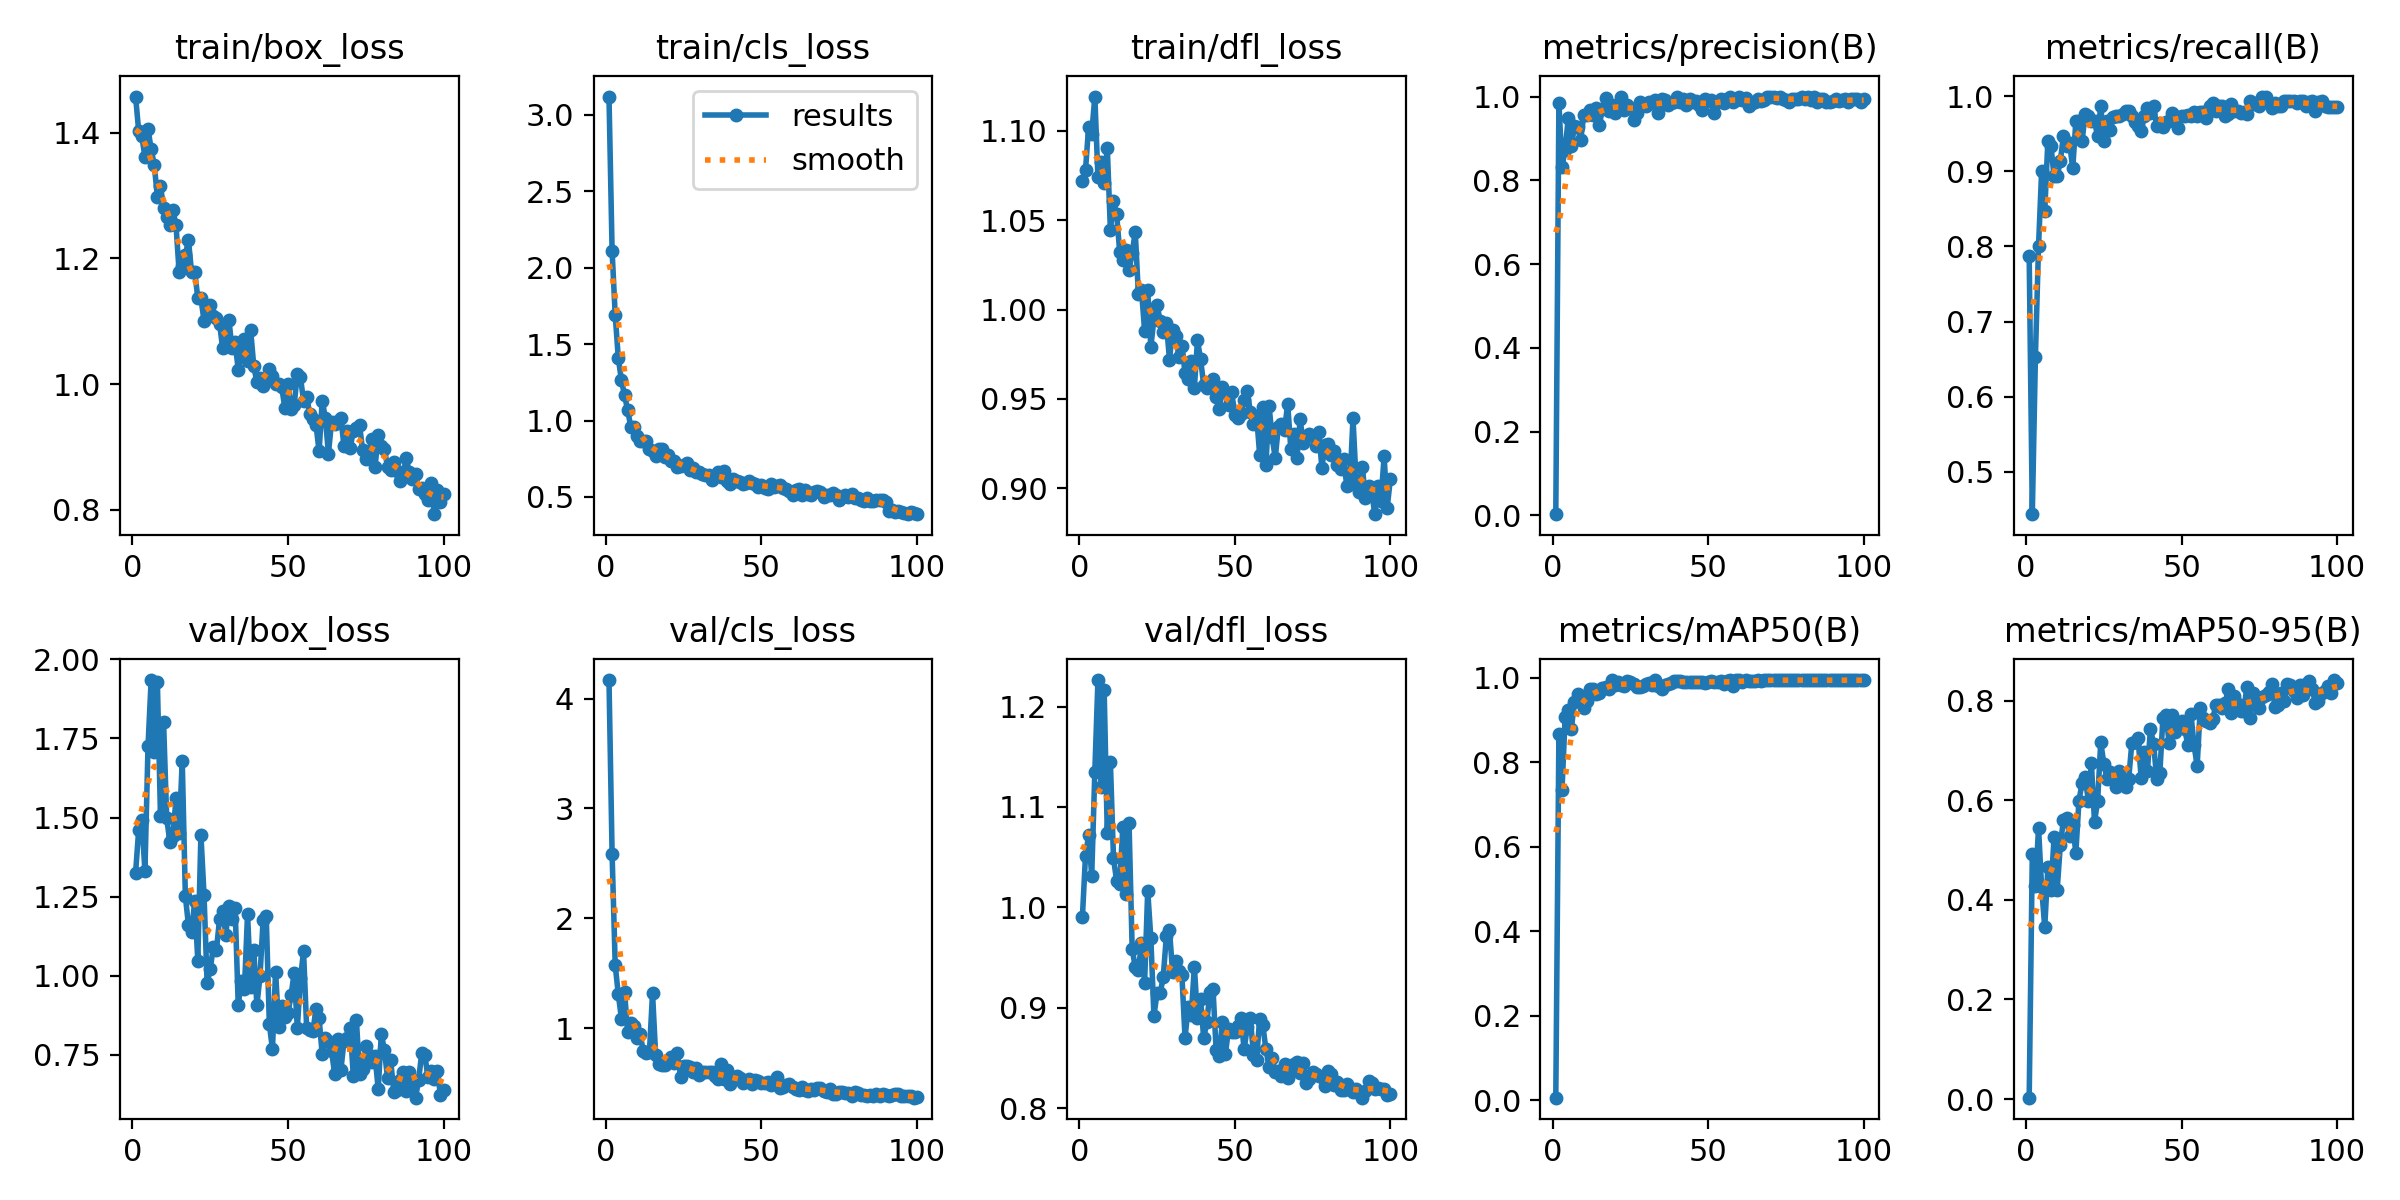

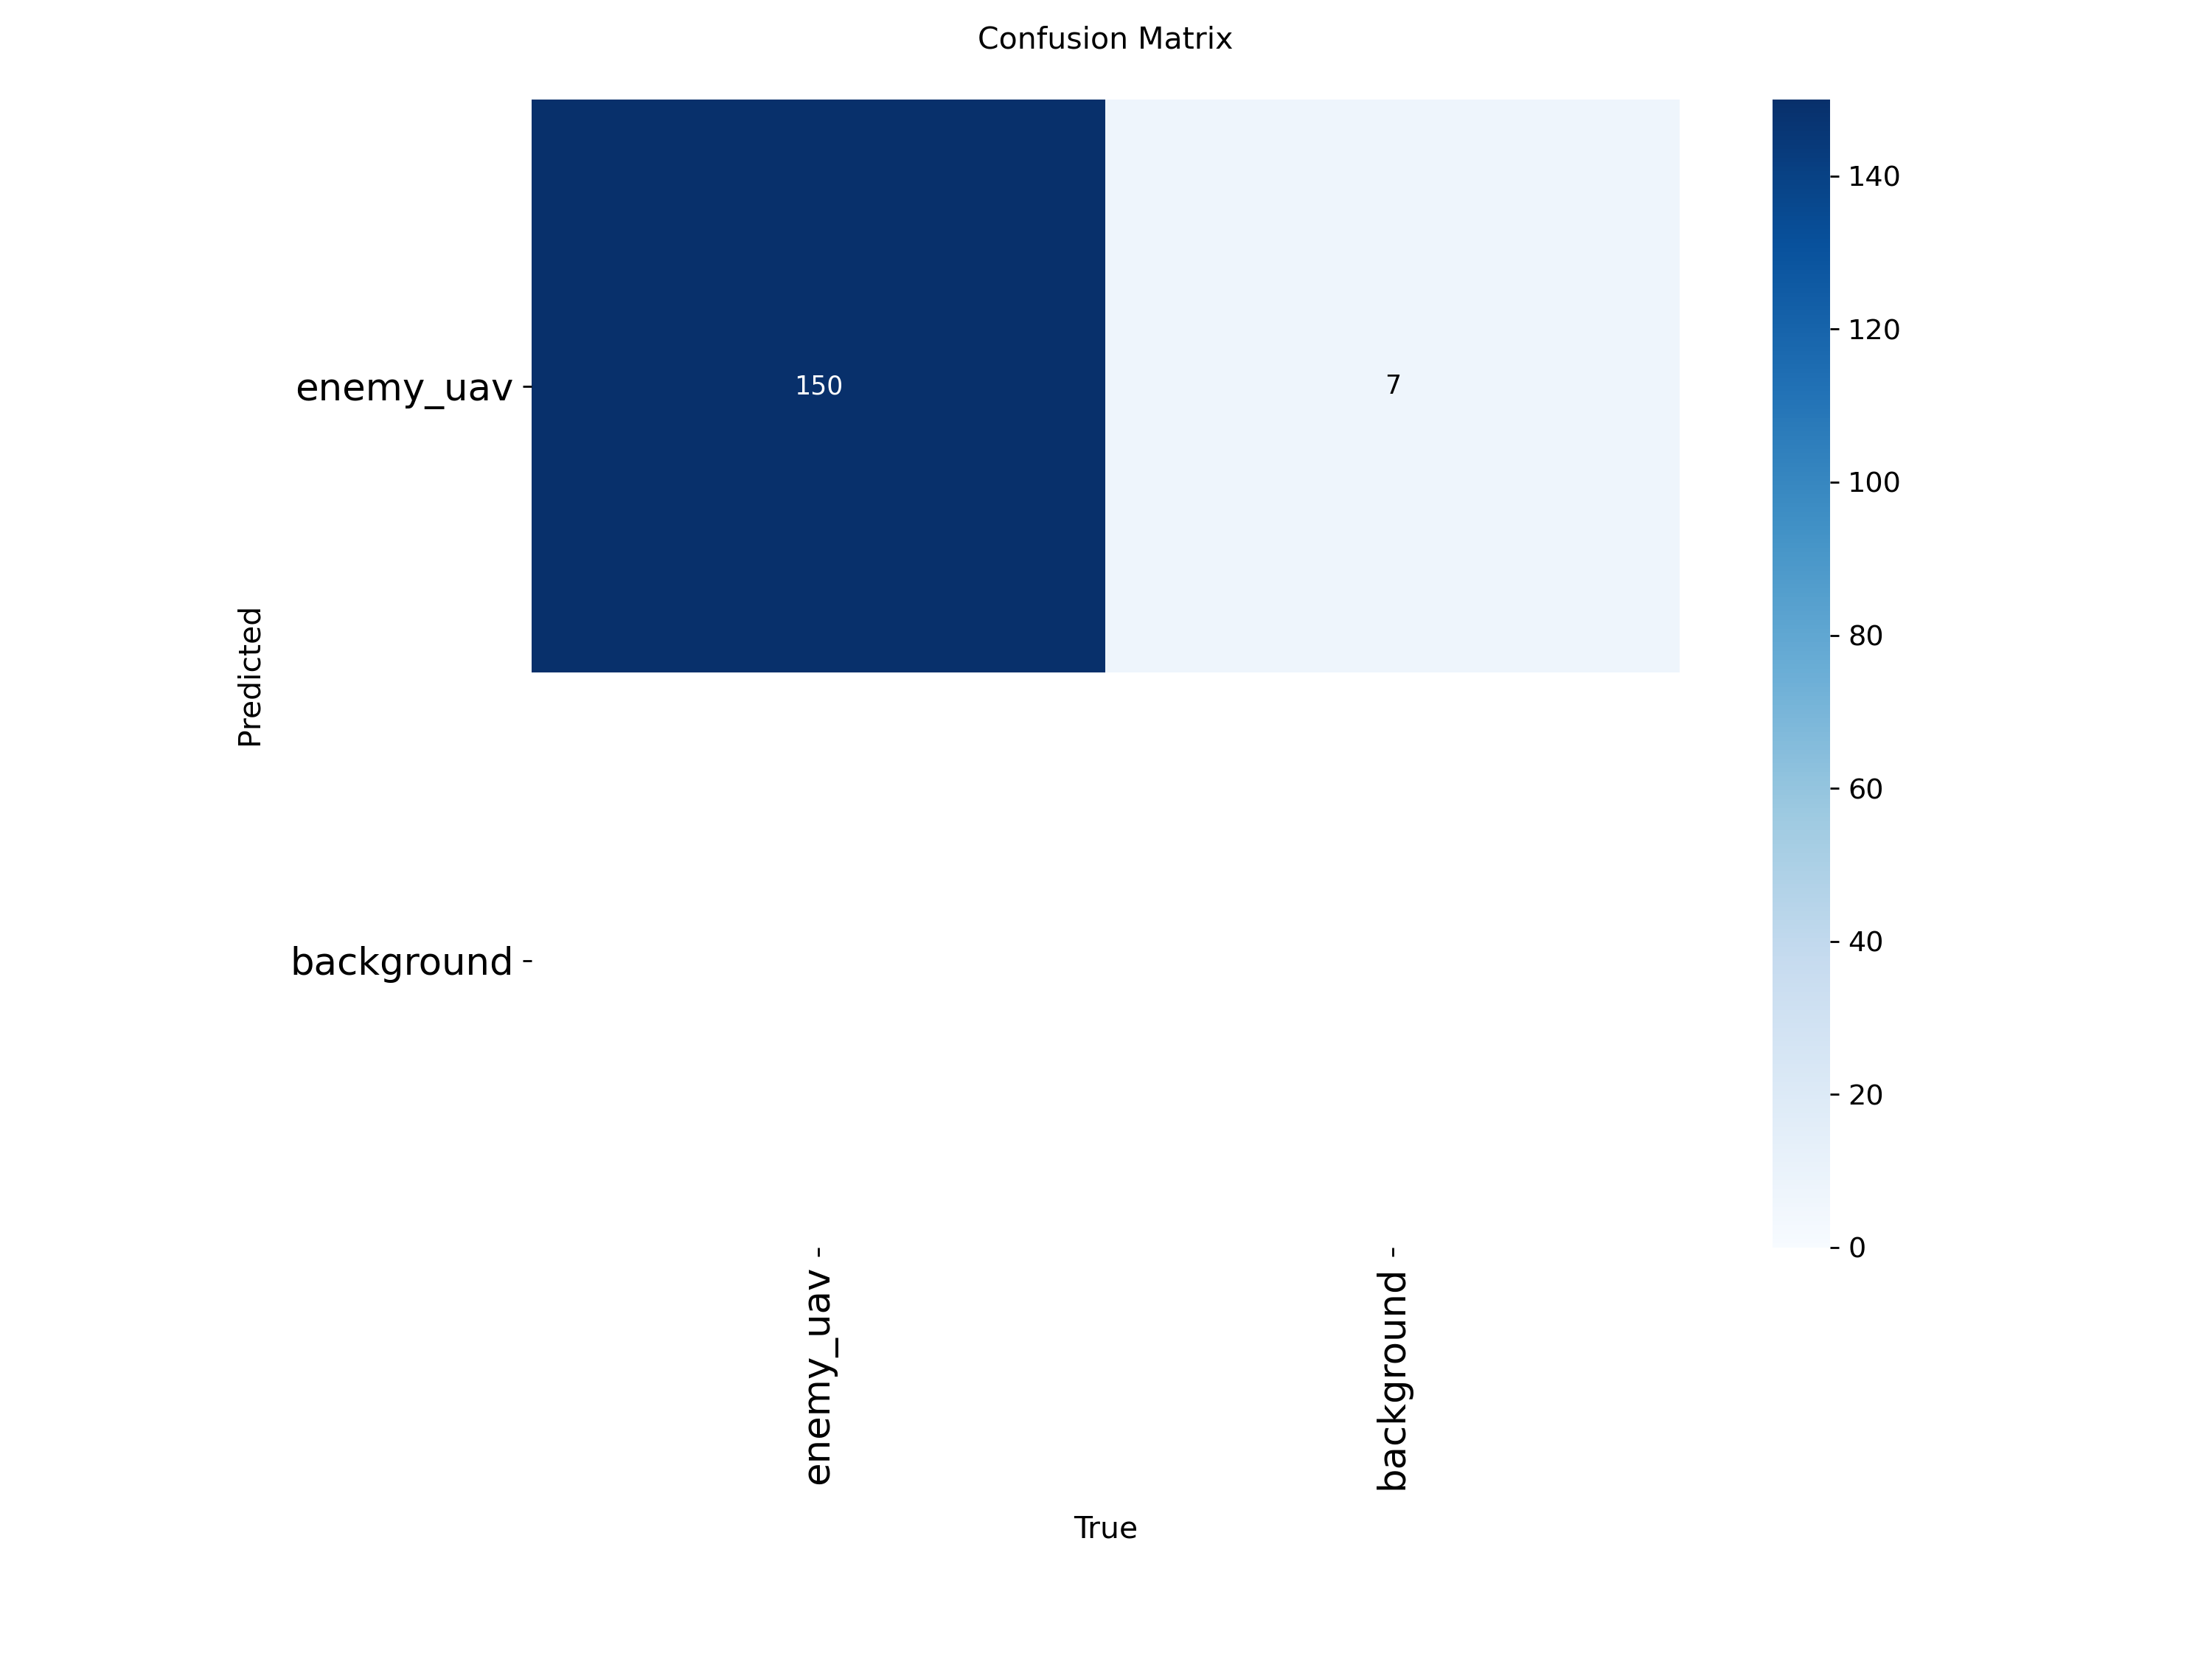

In [7]:
# Visualize training results
from IPython.display import Image, display

display(Image(filename='runs/detect/simUAV_detector/results.png', width=800))
display(Image(filename='runs/detect/simUAV_detector/confusion_matrix.png', width=600))

In [8]:
# Run inference on test images
test_images = '/content/yolo_dataset/images/test/'

results = model.predict(
    source=test_images,
    save=True,
    conf=0.25,
    iou=0.45,
    show_labels=True,
    show_conf=True
)

# Display sample predictions
import glob

pred_images = glob.glob('runs/detect/predict/*.png')[:4]
fig, axes = plt.subplots(1, len(pred_images), figsize=(16, 4))

for ax, img_path in zip(axes, pred_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


image 1/50 /content/yolo_dataset/images/test/img_000006.png: 640x640 1 enemy_uav, 7.2ms
image 2/50 /content/yolo_dataset/images/test/img_000025.png: 640x640 1 enemy_uav, 7.2ms
image 3/50 /content/yolo_dataset/images/test/img_000027.png: 640x640 1 enemy_uav, 7.2ms
image 4/50 /content/yolo_dataset/images/test/img_000030.png: 640x640 1 enemy_uav, 7.2ms
image 5/50 /content/yolo_dataset/images/test/img_000032.png: 640x640 1 enemy_uav, 7.2ms
image 6/50 /content/yolo_dataset/images/test/img_000089.png: 640x640 1 enemy_uav, 7.2ms
image 7/50 /content/yolo_dataset/images/test/img_000095.png: 640x640 1 enemy_uav, 7.2ms
image 8/50 /content/yolo_dataset/images/test/img_000104.png: 640x640 1 enemy_uav, 7.2ms
image 9/50 /content/yolo_dataset/images/test/img_000114.png: 640x640 1 enemy_uav, 7.7ms
image 10/50 /content/yolo_dataset/images/test/img_000142.png: 640x640 1 enemy_uav, 9.9ms
image 11/50 /content/yolo_dataset/images/test/img_000159.png: 640x640 (no detections), 7.2ms
image 12/50 /content/yolo

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1600x400 with 0 Axes>

In [9]:
# Export best.pt to Google Drive
!cp runs/detect/simUAV_detector/weights/best.pt /content/drive/MyDrive/best.pt

print("best.pt saved to Google Drive")
print("Next: Download best.pt and run airsim_tracker.py")

best.pt saved to Google Drive
Next: Download best.pt and run airsim_tracker.py
